# Identify Data Sources:

Data Source
For this project, we utilized a publicly available dataset from Kaggle:

Dataset Name: Food Wastage Data in Restaurant
Source: Kaggle - Trevin Hannibal
Type: CSV file
Description: The dataset contains information about food types, number of guests, event types, storage conditions, purchase history, and food wastage amounts. It enables exploration of patterns in food waste across restaurant operations.
This dataset is directly aligned with the goal of the project: to identify patterns and reduce food wastage through data-driven analysis.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import shap
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set Up Data Collection:

In [24]:
data = pd.read_csv('food_waste.csv')

In [25]:
data.head()

,Type of Food,Number of Guests,Event Type,Quantity of Food,Storage Conditions,Purchase History,Seasonality,Preparation Method,Geographical Location,Pricing,Wastage Food Amount
0,Meat,310.0,Corporate,450.0,Refrigerated,Regular,All Seasons,Buffet,Urban,Low,25
1,Meat,400.0,Birthday,500.0,Room Temperature,Regular,Winter,Buffet,Suburban,High,40
2,Vegetables,302.0,Birthday,371.0,Refrigerated,Regular,Summer,Buffet,Suburban,Low,27
3,Meat,491.0,Birthday,497.0,Refrigerated,Regular,All Seasons,Finger Food,Rural,High,32
4,Meat,300.0,Corporate,400.0,Refrigerated,Regular,Winter,Finger Food,Urban,Moderate,25


 ### Data Cleaning
 Steps taken:

Normalized column names for consistency using lowercase and underscores.

Handled missing values:

Replaced missing number_of_guests and quantity_of_food with their median.

Dropped duplicates to avoid data skew.

Identified and flagged outliers in wastage_food_amount using both IQR and Z-Score.

Normalized numerical features using Min-Max Scaling.

Checked unique values for categorical columns to prepare for encoding and analysis.

In [26]:
data.rename(columns=lambda x: x.replace(' ', '_').lower(), inplace=True)

In [27]:
data.head()

,type_of_food,number_of_guests,event_type,quantity_of_food,storage_conditions,purchase_history,seasonality,preparation_method,geographical_location,pricing,wastage_food_amount
0,Meat,310.0,Corporate,450.0,Refrigerated,Regular,All Seasons,Buffet,Urban,Low,25
1,Meat,400.0,Birthday,500.0,Room Temperature,Regular,Winter,Buffet,Suburban,High,40
2,Vegetables,302.0,Birthday,371.0,Refrigerated,Regular,Summer,Buffet,Suburban,Low,27
3,Meat,491.0,Birthday,497.0,Refrigerated,Regular,All Seasons,Finger Food,Rural,High,32
4,Meat,300.0,Corporate,400.0,Refrigerated,Regular,Winter,Finger Food,Urban,Moderate,25


In [28]:
data.shape

(1782, 11)

data.columns

In [29]:
data.dtypes

type_of_food              object
number_of_guests         float64
event_type                object
quantity_of_food         float64
storage_conditions        object
purchase_history          object
seasonality               object
preparation_method        object
geographical_location     object
pricing                   object
wastage_food_amount        int64
dtype: object

# Check for nulls

In [30]:

print(data.isnull().sum())

type_of_food             0
number_of_guests         2
event_type               0
quantity_of_food         3
storage_conditions       0
purchase_history         0
seasonality              0
preparation_method       0
geographical_location    0
pricing                  0
wastage_food_amount      0
dtype: int64


### Let's Handle Those Missing Values
 Fill with Mean or Median
 
Since both are numerical features, we can fill missing values using the mean or median depending on distribution.

 we  prefer median (more robust to outliers)




In [31]:
data['number_of_guests'].fillna(data['number_of_guests'].median(), inplace=True)
data['quantity_of_food'].fillna(data['quantity_of_food'].median(), inplace=True)


In [32]:
print("Missing values after cleanup:\n", data.isnull().sum())


Missing values after cleanup:
 type_of_food             0
number_of_guests         0
event_type               0
quantity_of_food         0
storage_conditions       0
purchase_history         0
seasonality              0
preparation_method       0
geographical_location    0
pricing                  0
wastage_food_amount      0
dtype: int64


# Drop duplicates



In [33]:
duplicates_exist = data.duplicated().any()
print(duplicates_exist)  # True if duplicates exist, False otherwise


True


In [34]:
data = data.drop_duplicates()

In [35]:
duplicates_exist = data.duplicated().any()
print(duplicates_exist)  # True if duplicates exist, False otherwise

False


# checking for outliers or unexpected values in numerical columns.

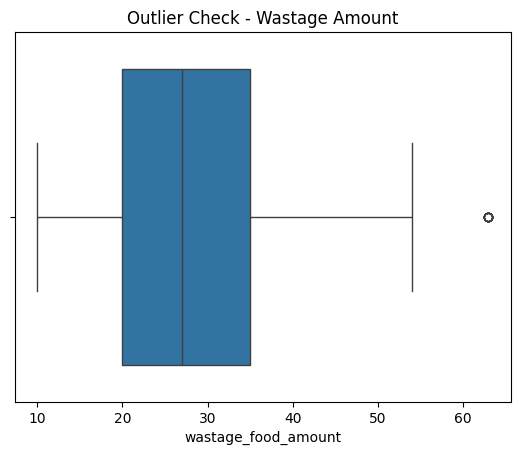

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize outliers
sns.boxplot(x=data['wastage_food_amount'])
plt.title("Outlier Check - Wastage Amount")
plt.show()


In [37]:
Q1 = data['wastage_food_amount'].quantile(0.25)
Q3 = data['wastage_food_amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data[(data['wastage_food_amount'] < lower_bound) | (data['wastage_food_amount'] > upper_bound)]
print(outliers)


        type_of_food  number_of_guests        event_type  quantity_of_food  \
211   Dairy Products             488.0         Corporate             498.0   
263           Fruits             488.0         Corporate             498.0   
334      Baked Goods             488.0         Corporate             498.0   
852             Meat             488.0  Social Gathering             498.0   
928             Meat             488.0           Wedding             498.0   
1007     Baked Goods             488.0           Wedding             498.0   
1298          Fruits             488.0  Social Gathering             498.0   
1327  Dairy Products             488.0         Corporate             498.0   
1741     Baked Goods             488.0         Corporate             498.0   

     storage_conditions purchase_history  seasonality preparation_method  \
211    Room Temperature          Regular       Summer        Finger Food   
263    Room Temperature          Regular       Summer        Finger

In [38]:
from scipy.stats import zscore

data['z_score'] = zscore(data['wastage_food_amount'])

# Set threshold (e.g., > 3 or < -3)
outliers = data[(data['z_score'].abs() > 3)]
print(outliers)


        type_of_food  number_of_guests        event_type  quantity_of_food  \
211   Dairy Products             488.0         Corporate             498.0   
263           Fruits             488.0         Corporate             498.0   
334      Baked Goods             488.0         Corporate             498.0   
852             Meat             488.0  Social Gathering             498.0   
928             Meat             488.0           Wedding             498.0   
1007     Baked Goods             488.0           Wedding             498.0   
1298          Fruits             488.0  Social Gathering             498.0   
1327  Dairy Products             488.0         Corporate             498.0   
1741     Baked Goods             488.0         Corporate             498.0   

     storage_conditions purchase_history  seasonality preparation_method  \
211    Room Temperature          Regular       Summer        Finger Food   
263    Room Temperature          Regular       Summer        Finger

In [39]:
outliers = data[(data['wastage_food_amount'] < lower_bound) | (data['wastage_food_amount'] > upper_bound)]
print("Outliers found:\n", outliers)


Outliers found:
         type_of_food  number_of_guests        event_type  quantity_of_food  \
211   Dairy Products             488.0         Corporate             498.0   
263           Fruits             488.0         Corporate             498.0   
334      Baked Goods             488.0         Corporate             498.0   
852             Meat             488.0  Social Gathering             498.0   
928             Meat             488.0           Wedding             498.0   
1007     Baked Goods             488.0           Wedding             498.0   
1298          Fruits             488.0  Social Gathering             498.0   
1327  Dairy Products             488.0         Corporate             498.0   
1741     Baked Goods             488.0         Corporate             498.0   

     storage_conditions purchase_history  seasonality preparation_method  \
211    Room Temperature          Regular       Summer        Finger Food   
263    Room Temperature          Regular       Sum

# Reslove outliers 

In [40]:
from sklearn.preprocessing import MinMaxScaler

# Create a copy of the original data
normalized_data = data.copy()

# Columns to normalize
columns_to_normalize = ['number_of_guests', 'quantity_of_food', 'wastage_food_amount']

scaler = MinMaxScaler()
normalized_data[columns_to_normalize] = scaler.fit_transform(normalized_data[columns_to_normalize])

print(normalized_data.head())


  type_of_food  number_of_guests event_type  quantity_of_food  \
0         Meat          0.362676  Corporate          0.772727   
1         Meat          0.679577   Birthday          1.000000   
2   Vegetables          0.334507   Birthday          0.413636   
3         Meat          1.000000   Birthday          0.986364   
4         Meat          0.327465  Corporate          0.545455   

  storage_conditions purchase_history  seasonality preparation_method  \
0       Refrigerated          Regular  All Seasons             Buffet   
1   Room Temperature          Regular       Winter             Buffet   
2       Refrigerated          Regular       Summer             Buffet   
3       Refrigerated          Regular  All Seasons        Finger Food   
4       Refrigerated          Regular       Winter        Finger Food   

  geographical_location   pricing  wastage_food_amount   z_score  
0                 Urban       Low             0.283019 -0.349881  
1              Suburban      High   

# Check Unique Values in Categorical Columns

In [41]:
print(data['type_of_food'].unique())
print(data['event_type'].unique())
print(data['storage_conditions'].unique())
print(data['purchase_history'].unique())
print(data['seasonality'].unique())
print(data['preparation_method'].unique())
print(data['geographical_location'].unique())
print(data['pricing'].unique())

       

['Meat' 'Vegetables' 'Fruits' 'Baked Goods' 'Dairy Products']
['Corporate' 'Birthday' 'Wedding' 'Social Gathering']
['Refrigerated' 'Room Temperature']
['Regular' 'Occasional']
['All Seasons' 'Winter' 'Summer']
['Buffet' 'Finger Food' 'Sit-down Dinner']
['Urban' 'Suburban' 'Rural']
['Low' 'High' 'Moderate']


In [42]:
# Look at value counts

print(data['type_of_food'].value_counts())
print(data['event_type'].value_counts())
print(data['storage_conditions'].value_counts())
print(data['purchase_history'].value_counts())
print(data['seasonality'].value_counts())
print(data['preparation_method'].value_counts())
print(data['geographical_location'].value_counts())
print(data['pricing'].value_counts())



type_of_food
Meat              398
Baked Goods       367
Dairy Products    348
Fruits            303
Vegetables        203
Name: count, dtype: int64
event_type
Corporate           463
Social Gathering    417
Wedding             407
Birthday            332
Name: count, dtype: int64
storage_conditions
Room Temperature    1037
Refrigerated         582
Name: count, dtype: int64
purchase_history
Regular       1418
Occasional     201
Name: count, dtype: int64
seasonality
Winter         580
All Seasons    549
Summer         490
Name: count, dtype: int64
preparation_method
Sit-down Dinner    721
Finger Food        627
Buffet             271
Name: count, dtype: int64
geographical_location
Suburban    746
Urban       513
Rural       360
Name: count, dtype: int64
pricing
High        613
Moderate    596
Low         410
Name: count, dtype: int64


# Data Storage:

Set up a data storage solution that suits your needs. This could be a local database, cloud storage, or a data warehouse.

In [43]:
import sqlite3

# Connect or create a local DB
conn = sqlite3.connect('restaurant_waste.db')

# Save to table
data.to_sql('food_waste', conn, if_exists='replace', index=False)

# Verify save
print(pd.read_sql("SELECT * FROM food_waste LIMIT 5", conn))

conn.close()


  type_of_food  number_of_guests event_type  quantity_of_food  \
0         Meat             310.0  Corporate             450.0   
1         Meat             400.0   Birthday             500.0   
2   Vegetables             302.0   Birthday             371.0   
3         Meat             491.0   Birthday             497.0   
4         Meat             300.0  Corporate             400.0   

  storage_conditions purchase_history  seasonality preparation_method  \
0       Refrigerated          Regular  All Seasons             Buffet   
1   Room Temperature          Regular       Winter             Buffet   
2       Refrigerated          Regular       Summer             Buffet   
3       Refrigerated          Regular  All Seasons        Finger Food   
4       Refrigerated          Regular       Winter        Finger Food   

  geographical_location   pricing  wastage_food_amount   z_score  
0                 Urban       Low                   25 -0.349881  
1              Suburban      High   

In [44]:

# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")




In [45]:
df=data

In [46]:
# Step 4: Encode Categorical Variables
label_encoders = {}
categorical_columns = ['type_of_food', 'event_type', 'storage_conditions',
                       'purchase_history', 'seasonality', 'preparation_method',
                       'geographical_location', 'pricing']


In [47]:

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le



In [48]:
# Step 5: Define Features and Target
X = df.drop(columns=['wastage_food_amount', 'z_score'])  # Feature set
y = df['wastage_food_amount']                             # Target variable



In [49]:
# Step 6: Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5]
}

grid_search = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid, scoring='r2', cv=3)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best XGBoost Parameters:", best_params)

Best XGBoost Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [50]:
# Step 9: Import Other Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Step 10: Define and Train All Models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', **best_params)
}



In [51]:
#Step 11: Train, Predict, Evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MAE': round(mae, 4),
        'RMSE': round(rmse, 4),
        'R2 Score': round(r2, 4)
    })

# Step 12: Display Evaluation Results
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:\n")
print(results_df.sort_values(by="R2 Score", ascending=False))

# Optional: Cross-Validation for Best Model (XGBoost)
best_model = models["XGBoost"]
cv_scores = cross_val_score(best_model, X, y, scoring='r2', cv=5)
print("\nXGBoost Cross-Validation R2 Scores:", cv_scores)
print("Mean CV R2 Score:", np.mean(cv_scores))



Model Performance Comparison:

                      Model     MAE    RMSE  R2 Score
5                   XGBoost  1.9236  2.7438    0.9306
2             Random Forest  1.7609  2.9152    0.9217
1             Decision Tree  1.6821  3.5213    0.8857
4             KNN Regressor  4.4340  5.8673    0.6828
3  Support Vector Regressor  4.8139  6.4151    0.6208
0         Linear Regression  5.2919  6.6040    0.5982

XGBoost Cross-Validation R2 Scores: [0.91137101 0.93776355 0.93309587 0.90663426 0.9010145 ]
Mean CV R2 Score: 0.9179758377332187


### best Model XGBoost 


  Model     MAE    RMSE  R2 Score
  
5   XGBoost  1.9236  2.7438    0.9306